In [1]:
import numpy as np
import pandas as pd

In [2]:
df=pd.read_csv('spam.csv', encoding='latin1', on_bad_lines='skip')

In [3]:
df.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
642,ham,Probably gonna swing by in a wee bit,NaN,NaN,NaN
4967,ham,Future is not what we planned for tomorrow.......,NaN,NaN,NaN
5117,ham,Aslamalaikkum....insha allah tohar beeen muht ...,NaN,NaN,NaN
4037,ham,Hope you are not scared!,NaN,NaN,NaN
2469,ham,* Am on my way,NaN,NaN,NaN


In [4]:
df.shape

(5572, 5)

## Data Cleaning

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [6]:
# since last 3 columns are redundant, we drop them
df.drop(columns=['Unnamed: 2','Unnamed: 3', 'Unnamed: 4'], inplace=True)

In [7]:
df.sample(5)

,v1,v2
94,ham,Havent planning to buy later. I check already ...
2122,ham,Do you know when the result.
3517,ham,Are you willing to go for apps class.
3415,ham,Uhhhhrmm isnt having tb test bad when youre sick
4969,ham,We are supposed to meet to discuss abt our tri...


In [8]:
df.rename(columns = {'v1':'target', 'v2':'text'}, inplace = True)
df.sample(5)

,target,text
5325,ham,Gal n boy walking in d park. gal-can i hold ur...
5455,ham,Wishing you a beautiful day. Each moment revea...
4120,ham,Yunny... I'm goin to be late
2296,spam,<Forwarded from 21870000>Hi - this is your Mai...
3735,ham,Hows the street where the end of library walk is?


In [9]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [10]:
df['target'] = encoder.fit_transform(df['target'])
df.sample(5)

,target,text
4969,0,We are supposed to meet to discuss abt our tri...
1120,0,Cancel cheyyamo?and get some money back?
3254,0,HI ITS KATE CAN U GIVE ME A RING ASAP XXX
2821,1,ROMCAPspam Everyone around should be respondin...
1867,0,Mmmm ... Fuck ... Not fair ! You know my weakn...


In [11]:
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [12]:
df.isnull().sum()


target    0
text      0
dtype: int64

In [13]:
df.duplicated().sum()

np.int64(403)

In [14]:
df =df.drop_duplicates(keep='first')

In [15]:
df.shape

(5169, 2)

In [16]:
df['target'].value_counts()

target
0    4516
1     653
Name: count, dtype: int64

([<matplotlib.patches.Wedge at 0x18271e55be0>,
 [Text(-1.014499732282844, 0.4251944181172162, 'ham'),
  Text(1.0144998708287172, -0.42519408755122207, 'spam')],
 [Text(-0.5533634903360967, 0.2319242280639361, '87.37'),
  Text(0.553363565906573, -0.231924047755212, '12.63')])

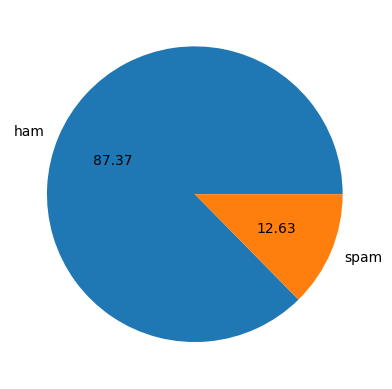

In [17]:
import matplotlib.pyplot as plt
plt.pie(df['target'].value_counts(), labels=['ham', 'spam'], autopct='%0.2f')

In [18]:
import nltk


In [19]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to C:\Users\nikhi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\nikhi/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nikhi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
df['num_characters']= df['text'].apply(len)

In [21]:
df.head()

,target,text,num_characters
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [22]:
df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))


In [23]:
df['num_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [24]:
df.head()

,target,text,num_characters,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [25]:
df[['num_characters', 'num_words', 'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [26]:
df[df['target']==0][['num_characters', 'num_words', 'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [27]:
df[df['target']==1][['num_characters', 'num_words', 'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


In [28]:
import seaborn as sns

<Axes: xlabel='num_characters', ylabel='Count'>

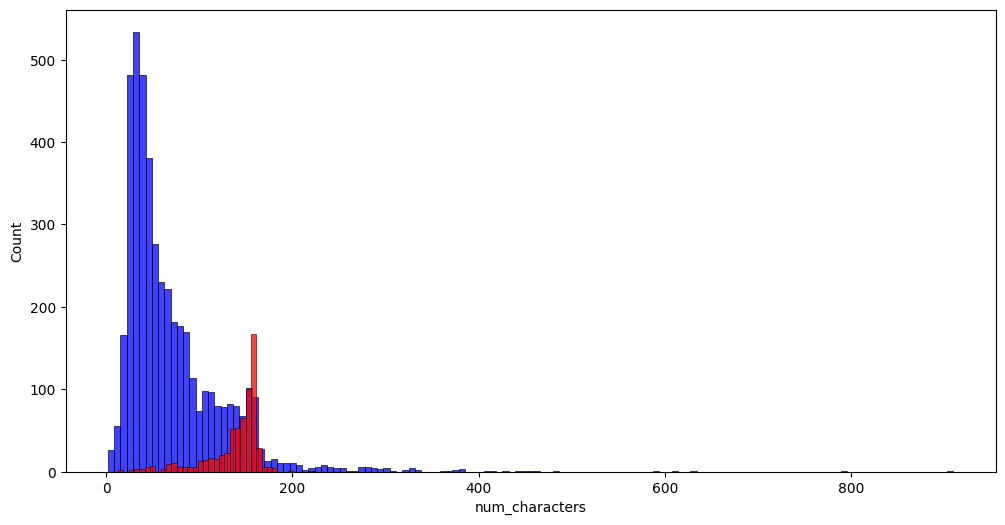

In [29]:
plt.figure(figsize=(12, 6))
sns.histplot(df[df['target']==0]['num_characters'], color='blue', label='ham')
sns.histplot(df[df['target']==1]['num_characters'], color='red')

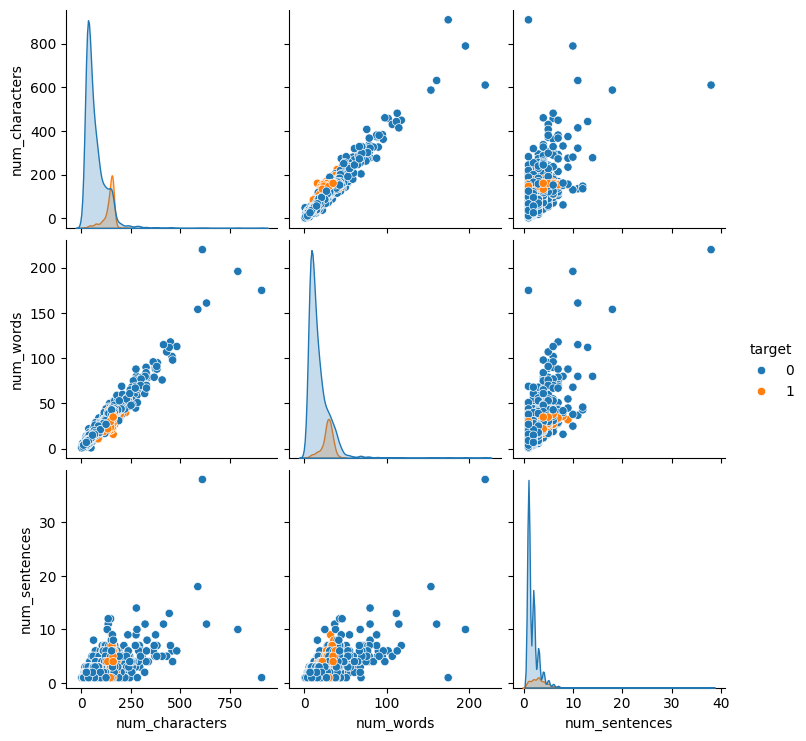

In [30]:
sns.pairplot(df,hue='target')

<Axes: >

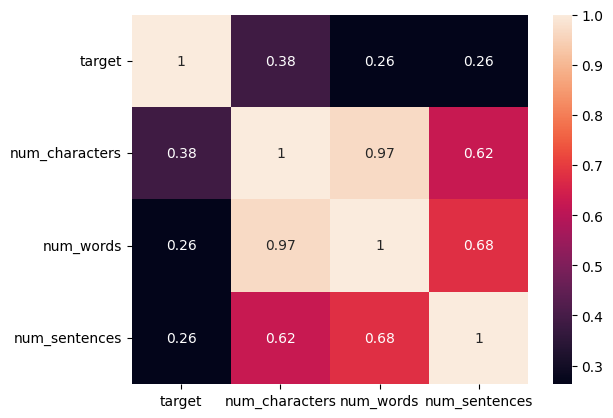

In [31]:
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True)

**Data Processing**
- Lowercase
- Tokenize
- Remove Special chars
- Removing stop words and punctuation
- Stemming

In [32]:
from nltk.corpus import stopwords
stopwords.words('english')
import string
string.punctuation
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer() 


In [33]:
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    y =[]
    for i in text:
        if i.isalnum():
            y.append(i)
    
    text = y[:]
    y.clear()
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)

    text = y[:]
    y.clear()
    for i in text:
        y.append(stemmer.stem(i))
    return " ".join(y)

In [34]:
transform_text('Hey i just saw your project you have been working on. I love it!')

'hey saw project work love'

In [35]:
df['transformed_text']=df['text'].apply(transform_text)
df.head()

,target,text,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [36]:
from wordcloud import WordCloud
wc = WordCloud(width=500, height=500, min_font_size=10, background_color='white')


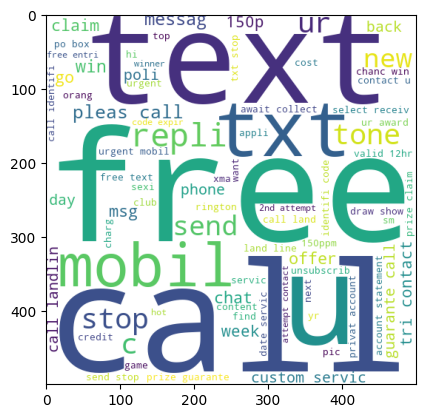

In [37]:
spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))
plt.Figure(figsize=(10, 10))
plt.imshow(spam_wc)

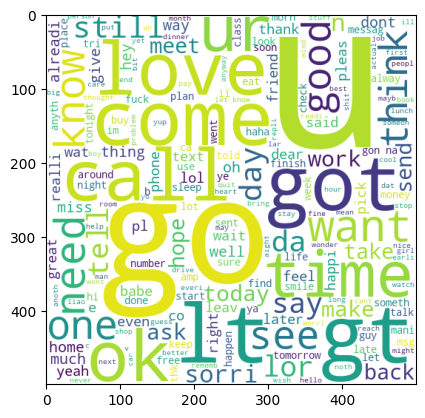

In [38]:
ham_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=" "))
plt.Figure(figsize=(10, 10))
plt.imshow(ham_wc)

In [39]:
spam_corpus = []
for message in df[df['target']==1]['transformed_text'].to_list():
    for word in message.split():
        spam_corpus.append(word)

ham_corpus = []
for message in df[df['target']==0]['transformed_text'].to_list():
    for word in message.split():
        ham_corpus.append(word)

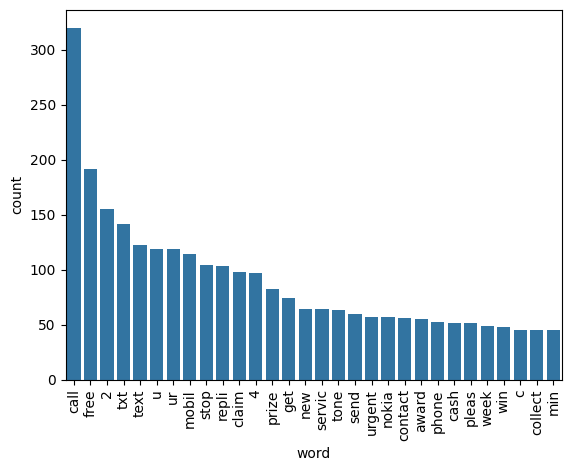

In [40]:
from collections import Counter

common_words = Counter(spam_corpus).most_common(30)
common_words_df = pd.DataFrame(common_words, columns=['word', 'count'])

sns.barplot(x='word', y='count', data=common_words_df)
plt.xticks(rotation='vertical')
plt.show()


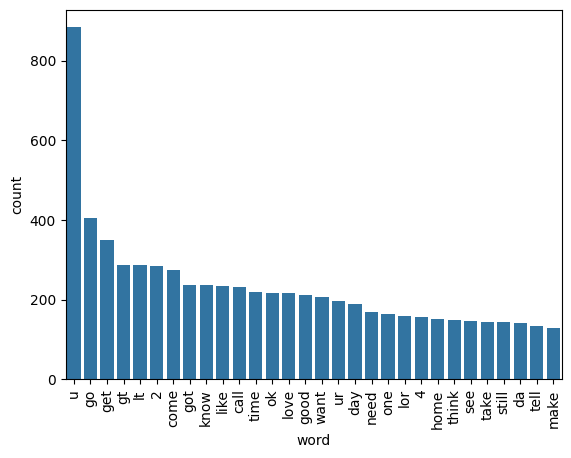

In [41]:
from collections import Counter

common_words = Counter(ham_corpus).most_common(30)
common_words_df = pd.DataFrame(common_words, columns=['word', 'count'])

sns.barplot(x='word', y='count', data=common_words_df)
plt.xticks(rotation='vertical')
plt.show()

**Model Building**

In [42]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
tfidf = TfidfVectorizer()
cv = CountVectorizer()

In [43]:
X = tfidf.fit_transform(df['transformed_text']).toarray()
y = df['target'].values

- Applying train test split

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [45]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [46]:
gnb.fit(X_train, y_train)
y_pred1 = gnb.predict(X_test)
print(accuracy_score(y_test, y_pred1))
print(confusion_matrix(y_test, y_pred1))
print(precision_score(y_test, y_pred1))

0.8762088974854932
[[793 103]
 [ 25 113]]
0.5231481481481481


In [47]:
mnb.fit(X_train, y_train)
y_pred2 = mnb.predict(X_test)
print(accuracy_score(y_test, y_pred2))
print(confusion_matrix(y_test, y_pred2))
print(precision_score(y_test, y_pred2))

0.9593810444874274
[[896   0]
 [ 42  96]]
1.0


In [48]:
bnb.fit(X_train, y_train)
y_pred3 = bnb.predict(X_test)
print(accuracy_score(y_test, y_pred3))
print(confusion_matrix(y_test, y_pred3))
print(precision_score(y_test, y_pred3))

0.9700193423597679
[[893   3]
 [ 28 110]]
0.9734513274336283


In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [50]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)

In [51]:
clfs = {
    'SVC' : svc,
    'KN' : knc, 
    'NB': mnb, 
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'AdaBoost': abc, 
    'BgC': bc, 
    'ETC': etc,
    'GBDT':gbdt,
}

In [52]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    
    return accuracy,precision

In [53]:
train_classifier(svc,X_train,y_train,X_test,y_test)

(0.9729206963249516, 0.9741379310344828)

In [54]:
accuracy_scores = []
precision_scores = []

for name,clf in clfs.items():
    
    current_accuracy,current_precision = train_classifier(clf, X_train,y_train,X_test,y_test)
    
    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

For  SVC
Accuracy -  0.9729206963249516
Precision -  0.9741379310344828
For  KN
Accuracy -  0.9003868471953579
Precision -  1.0
For  NB
Accuracy -  0.9593810444874274
Precision -  1.0
For  KN
Accuracy -  0.9003868471953579
Precision -  1.0
For  NB
Accuracy -  0.9593810444874274
Precision -  1.0
For  DT
Accuracy -  0.9352030947775629
Precision -  0.8380952380952381
For  LR
Accuracy -  0.9516441005802708
Precision -  0.94
For  DT
Accuracy -  0.9352030947775629
Precision -  0.8380952380952381
For  LR
Accuracy -  0.9516441005802708
Precision -  0.94
For  RF
Accuracy -  0.971953578336557
Precision -  1.0
For  RF
Accuracy -  0.971953578336557
Precision -  1.0
For  AdaBoost
Accuracy -  0.9245647969052224
Precision -  0.8409090909090909
For  AdaBoost
Accuracy -  0.9245647969052224
Precision -  0.8409090909090909
For  BgC
Accuracy -  0.9584139264990329
Precision -  0.8625954198473282
For  BgC
Accuracy -  0.9584139264990329
Precision -  0.8625954198473282
For  ETC
Accuracy -  0.9729206963249516


In [55]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Precision',ascending=False)
performance_df


,Algorithm,Accuracy,Precision
1,KN,0.900387,1.000000
2,NB,0.959381,1.000000
5,RF,0.971954,1.000000
8,ETC,0.972921,0.982456
0,SVC,0.972921,0.974138
4,LR,0.951644,0.940000
9,GBDT,0.952611,0.923810
7,BgC,0.958414,0.862595
6,AdaBoost,0.924565,0.840909
3,DT,0.935203,0.838095


In [56]:
performance_df1 = pd.melt(performance_df, id_vars = "Algorithm")
performance_df1

,Algorithm,variable,value
0,KN,Accuracy,0.900387
1,NB,Accuracy,0.959381
2,RF,Accuracy,0.971954
3,ETC,Accuracy,0.972921
4,SVC,Accuracy,0.972921
5,LR,Accuracy,0.951644
6,GBDT,Accuracy,0.952611
7,BgC,Accuracy,0.958414
8,AdaBoost,Accuracy,0.924565
9,DT,Accuracy,0.935203


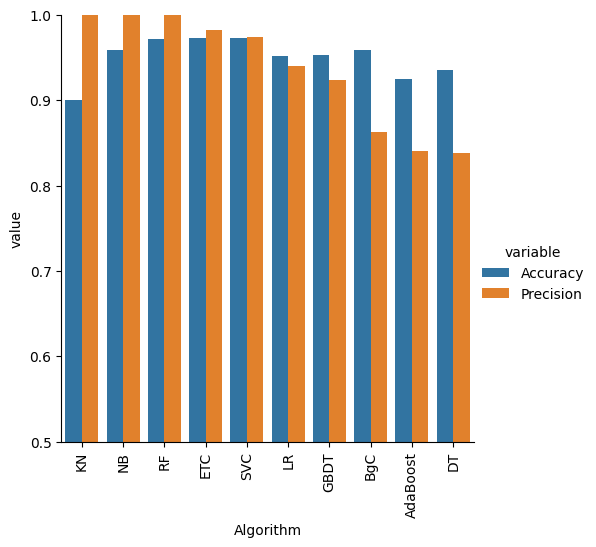

In [57]:
sns.catplot(x = 'Algorithm', y='value', 
               hue = 'variable',data=performance_df1, kind='bar',height=5)
plt.ylim(0.5,1.0)
plt.xticks(rotation='vertical')
plt.show()

fine tuning


In [58]:
temp_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy_scaling':accuracy_scores,'Precision_scaling':precision_scores}).sort_values('Precision_scaling',ascending=False)
new_df = performance_df.merge(temp_df,on='Algorithm')
new_df_scaled = new_df.merge(temp_df,on='Algorithm')
temp_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy_num_chars':accuracy_scores,'Precision_num_chars':precision_scores}).sort_values('Precision_num_chars',ascending=False)
new_df_scaled.merge(temp_df,on='Algorithm')

,Algorithm,Accuracy,Precision,Accuracy_scaling_x,Precision_scaling_x,Accuracy_scaling_y,Precision_scaling_y,Accuracy_num_chars,Precision_num_chars
0,KN,0.900387,1.000000,0.900387,1.000000,0.900387,1.000000,0.900387,1.000000
1,NB,0.959381,1.000000,0.959381,1.000000,0.959381,1.000000,0.959381,1.000000
2,RF,0.971954,1.000000,0.971954,1.000000,0.971954,1.000000,0.971954,1.000000
3,ETC,0.972921,0.982456,0.972921,0.982456,0.972921,0.982456,0.972921,0.982456
4,SVC,0.972921,0.974138,0.972921,0.974138,0.972921,0.974138,0.972921,0.974138
5,LR,0.951644,0.940000,0.951644,0.940000,0.951644,0.940000,0.951644,0.940000
6,GBDT,0.952611,0.923810,0.952611,0.923810,0.952611,0.923810,0.952611,0.923810
7,BgC,0.958414,0.862595,0.958414,0.862595,0.958414,0.862595,0.958414,0.862595
8,AdaBoost,0.924565,0.840909,0.924565,0.840909,0.924565,0.840909,0.924565,0.840909
9,DT,0.935203,0.838095,0.935203,0.838095,0.935203,0.838095,0.935203,0.838095


In [59]:
# Voting Classifier
svc = SVC(kernel='sigmoid', gamma=1.0,probability=True)
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)

from sklearn.ensemble import VotingClassifier

In [60]:
voting = VotingClassifier(estimators=[('svm', svc), ('nb', mnb), ('et', etc)],voting='soft')
voting.fit(X_train,y_train)


,estimators,"[('svm', ...), ('nb', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,C,1.0
,kernel,'sigmoid'
,degree,3
,gamma,1.0
,coef0,0.0


In [61]:
y_pred = voting.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Accuracy 0.9787234042553191
Precision 1.0


In [62]:
# Applying stacking
estimators=[('svm', svc), ('nb', mnb), ('et', etc)]
final_estimator=RandomForestClassifier()

In [63]:
from sklearn.ensemble import StackingClassifier
clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator)

In [64]:
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Accuracy 0.9816247582205029
Precision 0.9612403100775194


In [65]:
import pickle
pickle.dump(tfidf,open('vectorizer.pkl','wb'))
pickle.dump(mnb,open('model.pkl','wb'))
pickle.dump(transform_text, open('transform_text.pkl', 'wb'))